# Training and testing of objection detection network
Based on Faster-RCNN and this guide: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


In [1]:
# %%shell

# pip install cython
# # Install pycocotools, the version by default in Colab
# # has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
# pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

## Importing libraries and custom scripts


In [2]:
import sys
import os
import numpy as np
import torch
import torch.utils.data

sys.path.append(os.getcwd() + "/.." + "/scripts")


## Dataset class with new __getitem__ function

In [3]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import transforms as T






class CansDataset(torch.utils.data.Dataset):
    def __init__(self, root, train=True):
        if train is True:
            self.root = root + "/video1/train/"
        else:
            self.root = root +  "/video1/test/"

        self.imgs = list(sorted(os.listdir(os.path.join(self.root,"frames"))))
        self.bbox = list(sorted(os.listdir(os.path.join(self.root,"boundingboxes"))))
    
    def __getitem__(self, idx):
        # load images and bboxes
        img_path = os.path.join(self.root, "frames", self.imgs[idx])
        bbox_path = os.path.join(self.root, "boundingboxes", self.bbox[idx])
        img = Image.open(img_path).convert("RGB")
        img=np.array(img)
        img=torch.tensor(img)/255
        img=img.permute(2,0,1)

        bbox = []
        label = []
        lines = 0
        iscrowd = []
        with open(bbox_path, 'r') as f:
            for line in f:
                line = line.split(" ")
                id = line[0] # class label, 1=beer, 2=cola, 0=background
                id = 1 if id == 'beer' else 2
                xmin = float(line[1])
                ymin = float(line[2])
                xmax = float(line[3])
                ymax = float(line[4])
                bbox.append([xmin, ymin, xmax, ymax])
                label.append(id)
                lines += 1
                iscrowd.append(False)

        bbox = torch.as_tensor(bbox, dtype=torch.int64)
        labels = torch.as_tensor(label, dtype=torch.int64) #torch.ones((num_objs, ), dtype=torch.float32)
        image_id = torch.tensor([idx],dtype=torch.int64)
        area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        #iscrowd = torch.zeros((lines,), dtype=torch.int64)

        target = {}
        target["boxes"] = bbox
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # if no boxes
        # torch.zeros((0,4), dtype=torch.float32)




        return img, target

    def __len__(self):
        return len(self.imgs)

Test class

In [4]:

#root = os.getcwd()+'data/'#os.getcwd() + '/..' + '/data/'
sys.path.append(os.getcwd() + "/.." + "/scripts") 
sys.path.append(os.getcwd() + "/..") 
#print(os.getcwd())
#os.chdir(os.getcwd()+"/..")

#print(root)
root = os.getcwd() + "/data"


/home/andreasgp/MEGAsync/DTU/9. Semester/Deep Learning/object-tracking-project/02456-project/notebooks


## Adding pretrained model and modify numbers of classes

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [6]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:

from engine import train_one_epoch, evaluate

import utils
import transforms as T
from typing import List, Tuple





dataset = CansDataset(root, train=True)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)


print(images[0])

targets = [{k: v for k, v in t.items()} for t in targets]

output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
print(predictions)


/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)
/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)
/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)
/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  

tensor([[[0.4157, 0.3843, 0.4000,  ..., 0.2627, 0.2706, 0.2745],
         [0.4314, 0.3333, 0.3176,  ..., 0.2667, 0.2745, 0.2784],
         [0.4039, 0.3373, 0.3373,  ..., 0.2706, 0.2745, 0.2745],
         ...,
         [0.1020, 0.1059, 0.1059,  ..., 0.0784, 0.0824, 0.0863],
         [0.1020, 0.1059, 0.1059,  ..., 0.0745, 0.0784, 0.0824],
         [0.1020, 0.1059, 0.1059,  ..., 0.0706, 0.0784, 0.0824]],

        [[0.3451, 0.3137, 0.3333,  ..., 0.2196, 0.2275, 0.2314],
         [0.3608, 0.2667, 0.2510,  ..., 0.2235, 0.2314, 0.2353],
         [0.3373, 0.2706, 0.2706,  ..., 0.2275, 0.2314, 0.2314],
         ...,
         [0.1059, 0.1098, 0.1098,  ..., 0.0824, 0.0863, 0.0902],
         [0.1059, 0.1098, 0.1098,  ..., 0.0784, 0.0824, 0.0863],
         [0.1059, 0.1098, 0.1098,  ..., 0.0745, 0.0824, 0.0863]],

        [[0.2510, 0.2196, 0.2314,  ..., 0.1098, 0.1098, 0.1137],
         [0.2667, 0.1647, 0.1490,  ..., 0.1137, 0.1137, 0.1176],
         [0.2353, 0.1608, 0.1608,  ..., 0.1176, 0.1137, 0.

/home/andreasgp/.local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'boxes': tensor([[ 95.8833,  70.4793,  98.8308,  74.9326],
        [339.2789, 172.6481, 342.3292, 177.0851],
        [118.2065,  70.2848, 121.6399,  75.1335],
        [337.7913, 173.1829, 340.7607, 177.6350],
        [107.8852,  73.4296, 111.4254,  78.2192],
        [336.2707, 172.6907, 339.2202, 177.3283],
        [112.6856,  68.5356, 116.1017,  72.2409],
        [ 85.9910,  68.6093,  89.6953,  72.1990],
        [ 94.4929,  70.1254,  97.5095,  74.9013],
        [336.0566, 174.2758, 339.1342, 179.2238],
        [113.8617,  68.6174, 117.5487,  72.5666],
        [116.9116,  69.5277, 120.1948,  73.9525],
        [101.6804,  67.1029, 105.2216,  70.4787],
        [113.3761,  67.3142, 117.4538,  70.6864],
        [145.6271, 145.9099, 148.8657, 149.9354],
        [112.6569,  69.9626, 116.1978,  74.2383],
        [106.5201,  74.6284, 110.0565,  79.2513],
        [ 96.3913,  63.0128,  99.7321,  66.5187],
        [101.3273,  68.3083, 105.1025,  72.0007],
        [ 96.0314,  64.7750,  99.5378, 

In [8]:
# use our dataset and defined transformations
dataset = CansDataset(root, train=True)
dataset_test = CansDataset(root, train=False)
print("Oriignal dataset lengths are:")
print("training:",len(dataset))
print("test:",len(dataset_test))


# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
indices_test = torch.randperm(len(dataset_test)).tolist()

dataset = torch.utils.data.Subset(dataset, indices[:100])          #indices[:-973])
dataset_test = torch.utils.data.Subset(dataset_test,indices_test[:10]) #indices[-200:])

print("Augmented dataset lengths are:")
print("training:",len(dataset))
print("test:",len(dataset_test))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


Oriignal dataset lengths are:
training: 1273
test: 319
Augmented dataset lengths are:
training: 100
test: 10


In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:",device)

# our dataset has three classes only - background, beer and coke
num_classes = 3

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

device: cuda


In [10]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)  

  


/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)
/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)
/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)
/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  

Epoch: [0]  [ 0/50]  eta: 0:08:36  lr: 0.000107  loss: 1.4327 (1.4327)  loss_classifier: 1.1142 (1.1142)  loss_box_reg: 0.3163 (0.3163)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 10.3364  data: 0.2550  max mem: 2115
Epoch: [0]  [10/50]  eta: 0:06:34  lr: 0.001126  loss: 0.5950 (0.8273)  loss_classifier: 0.4316 (0.5681)  loss_box_reg: 0.2588 (0.2511)  loss_objectness: 0.0021 (0.0055)  loss_rpn_box_reg: 0.0018 (0.0026)  time: 9.8722  data: 0.0275  max mem: 2379
Epoch: [0]  [20/50]  eta: 0:04:57  lr: 0.002146  loss: 0.4060 (0.6151)  loss_classifier: 0.1771 (0.3754)  loss_box_reg: 0.2021 (0.2337)  loss_objectness: 0.0014 (0.0041)  loss_rpn_box_reg: 0.0010 (0.0019)  time: 9.8827  data: 0.0050  max mem: 2379
Epoch: [0]  [30/50]  eta: 0:03:18  lr: 0.003165  loss: 0.3837 (0.5263)  loss_classifier: 0.1224 (0.2893)  loss_box_reg: 0.2019 (0.2310)  loss_objectness: 0.0012 (0.0042)  loss_rpn_box_reg: 0.0010 (0.0019)  time: 9.9398  data: 0.0051  max mem: 2380
Epoch: 

In [11]:
evaluate(model, data_loader_test, device=device)

/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)


creating index...
index created!
Test:  [ 0/10]  eta: 0:00:23  model_time: 2.1783 (2.1783)  evaluator_time: 0.0017 (0.0017)  time: 2.3925  data: 0.2112  max mem: 2380
Test:  [ 9/10]  eta: 0:00:02  model_time: 2.0358 (2.0620)  evaluator_time: 0.0010 (0.0012)  time: 2.0872  data: 0.0230  max mem: 2380
Test: Total time: 0:00:20 (2.0942 s / it)
Averaged stats: model_time: 2.0358 (2.0620)  evaluator_time: 0.0010 (0.0012)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.750
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.420
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.300
 Average Recall     (AR) @[ IoU

In [75]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)


In [76]:
prediction

[{'boxes': tensor([[197.1672, 266.4175, 260.0488, 368.1767],
          [267.4392, 305.5348, 347.2775, 372.6104],
          [185.7189, 265.7662, 260.7258, 337.8066],
          [260.8628, 307.9590, 352.1191, 364.2162]], device='cuda:0'),
  'labels': tensor([1, 1, 2, 2], device='cuda:0'),
  'scores': tensor([0.9386, 0.9282, 0.1154, 0.0967], device='cuda:0')}]

In [77]:
# Plotting code
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

/tmp/ipykernel_11362/3082487489.py:50: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bbox = torch.as_tensor(bbox, dtype=torch.int64)


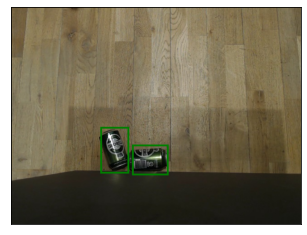

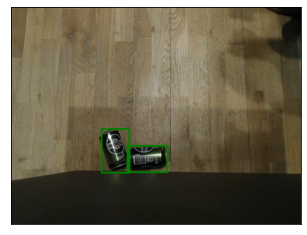

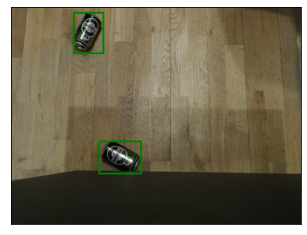

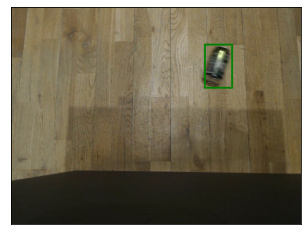

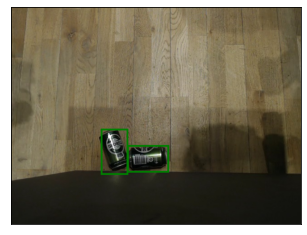

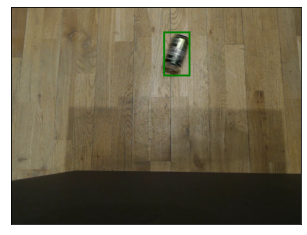

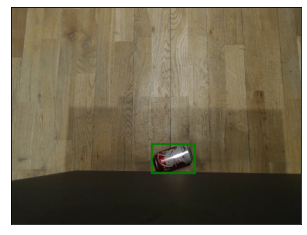

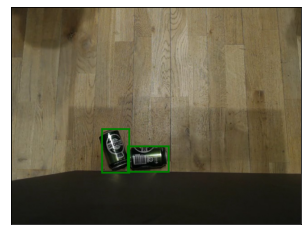

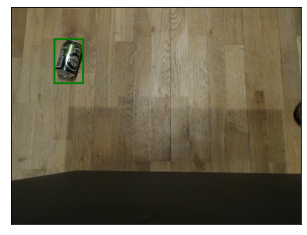

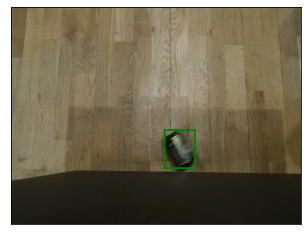

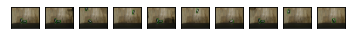

In [142]:


score_threshold = .8
cans_with_boxes = []
model.eval()
ALL_TEST_IMAGES = len(dataset_test)
HALF_TEST_IMAGES = ALL_TEST_IMAGES/2
THREE_IMAGES = 3
for i in range(ALL_TEST_IMAGES):
    img, _ = dataset_test[i]

    with torch.no_grad():
        output = model([img.to(device)])[0] # prediction
        img = img.mul(255).type(torch.uint8) # Bring to 0-255 from 0-1 and convert to usable type

        # extract boxes and scores for each color box
        green_boxes = {'boxes':output['boxes'][output['labels']==1],  'scores': output['scores'][output['labels']==1]}
        red_boxes =   {'boxes':output['boxes'][output['labels']==2],  'scores': output['scores'][output['labels']==2]}
        

        # only extract valid boxes
        valid_green_boxes = green_boxes['boxes'][green_boxes['scores'] > score_threshold]
        valid_red_boxes = red_boxes['boxes'][red_boxes['scores'] > score_threshold]

        # concat to one torch array
        boxes = torch.cat((valid_green_boxes, valid_red_boxes),0)

        # Add correct number of green and red boxes
        colors = [len(valid_green_boxes)*['green'], len(valid_red_boxes)*['red']]
        colors = [item for sublist in colors for item in sublist] # flatten list


        # Prepare for plotting
        draw = draw_bounding_boxes(img, boxes,colors=colors, width=4)
        show(draw)
        cans_with_boxes.append(draw)



        

# all in one plot
show(cans_with_boxes)

In [79]:
# If error with torch not releasing memory, delete model and empty cache. Start over
#del model
#torch.cuda.empty_cache()